# Keras Hyperparameter Tuning

In [1]:
import pandas as pd
from tensorflow import keras
from keras import layers
from keras import optimizers
from keras_tuner import RandomSearch

In [2]:
df = pd.read_csv("./datasets/Real_Combine.csv")
df

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1,154.037500
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6,223.208333
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2,200.645833
...,...,...,...,...,...,...,...,...,...
1088,18.1,24.0,11.2,1015.4,56.0,1.8,15.9,25.9,288.416667
1089,17.8,25.0,10.7,1015.8,54.0,2.3,9.4,22.2,256.833333
1090,13.9,24.5,11.4,1015.0,95.0,0.6,8.7,14.8,169.000000
1091,16.3,23.0,9.8,1016.9,78.0,1.1,7.4,16.5,186.041667


In [3]:
df = df.dropna()
df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    0
dtype: int64

In [4]:
# creation of feature set and target set
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

Hyperparameters

- How many number of hidden layers we should have?
- How many number of neurons we should have in hidden layers?
- Learning Rate

In [5]:
def hyper_tune(param):
    model = keras.Sequential()
    for i in range(param.Int("num_layers", 2, 20)):
        model.add(
            layers.Dense(
                units=param.Int(
                    "units_" + str(i), min_value=32, max_value=512, step=32
                ),
                activation="tanh",
            )
        )
    model.add(layers.Dense(1, activation="linear"))
    model.compile(
        optimizer=keras.optimizers.Adam(
            param.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
        ),
        loss="mean_absolute_error",
        metrics=["mean_absolute_error"],
    )
    return model

In [6]:
tuner = RandomSearch(
    hyper_tune,
    objective="val_mean_absolute_error",
    max_trials=5,
    executions_per_trial=3,
    directory="project",
    overwrite=True,
    project_name="Air Quality Index AQI",
)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 06s]
val_mean_absolute_error: 94.02474721272786

Best val_mean_absolute_error So Far: 68.3522237141927
Total elapsed time: 00h 00m 35s
INFO:tensorflow:Oracle triggered exit


In [9]:
# Get the best hyperparameters found during the search
best_hps = tuner.get_best_hyperparameters(1)[0]

# Build the model with the best hyperparameters
model = hyper_tune(best_hps)

In [10]:
# Train the model with the best hyperparameters on the full training set
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
24/24 [==============================] - 2s 11ms/step - loss: 98.7632 - mean_absolute_error: 98.7632 - val_loss: 82.1889 - val_mean_absolute_error: 82.1889
Epoch 2/5
24/24 [==============================] - 0s 7ms/step - loss: 86.3785 - mean_absolute_error: 86.3785 - val_loss: 76.1918 - val_mean_absolute_error: 76.1918
Epoch 3/5
24/24 [==============================] - 0s 6ms/step - loss: 80.9792 - mean_absolute_error: 80.9792 - val_loss: 72.5645 - val_mean_absolute_error: 72.5645
Epoch 4/5
24/24 [==============================] - 0s 6ms/step - loss: 77.1317 - mean_absolute_error: 77.1317 - val_loss: 70.1214 - val_mean_absolute_error: 70.1214
Epoch 5/5
24/24 [==============================] - 0s 6ms/step - loss: 74.2679 - mean_absolute_error: 74.2679 - val_loss: 68.4306 - val_mean_absolute_error: 68.4306


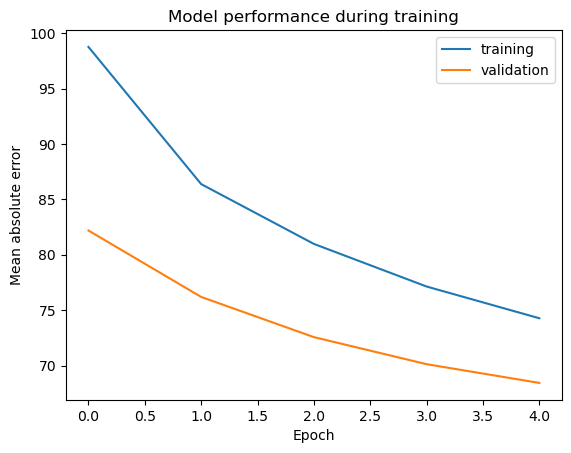

In [11]:
import matplotlib.pyplot as plt

# Plot the training and validation metrics for each epoch
plt.plot(history.history["mean_absolute_error"], label="training")
plt.plot(history.history["val_mean_absolute_error"], label="validation")
plt.title("Model performance during training")
plt.xlabel("Epoch")
plt.ylabel("Mean absolute error")
plt.legend()
plt.show()